In [3]:
# prompt: generate pandas dataframe with 1 columns as each row contains sequence or list which contains value 1-100 and it could be be of any size and second column as taget contains only 1 as value

import pandas as pd
import random

df = pd.read_csv('/content/train.csv', on_bad_lines='skip')
df.head()


,id,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


In [4]:
# prompt: above dataset drop id column and join rest column to make new column as sequence column where row is list. dont join class columns

new_df = df.drop('id', axis=1)
new_df['sequence'] = new_df.apply(lambda row: list(row[:-1]), axis=1)
new_df = new_df[['sequence', 'Class']]
print(new_df)


                                                 sequence  Class
0       [133.171875, 59.71608146, 0.043132924, -0.7033...      0
1       [87.09375, 36.25797326, 0.435468922, 2.2660569...      0
2       [112.640625, 39.81839348, 0.379638726, 0.92230...      0
3       [120.6796875, 45.91844777, -0.098490164, 0.011...      0
4       [134.0703125, 57.72010723, -0.107772078, -0.57...      0
...                                                   ...    ...
117559  [132.84375, 56.74883772, -0.060070048, -0.5540...      0
117560  [112.578125, 52.53927103, 0.179580122, -0.3069...      0
117561  [119.7578125, 49.9800131, 0.064401508, -0.2708...      0
117562  [105.7890625, 46.98659519, 0.441426486, 0.3724...      0
117563  [113.515625, 50.93595605, 0.031516691, -0.4438...      0

[117564 rows x 2 columns]


In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

# Custom Dataset class
class SequenceDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.long)
        y = torch.tensor(self.targets[index], dtype=torch.long)
        return x, y

In [6]:
# Load data from pandas dataframe
def prepare_data(df, input_col, target_col):
    input_sequences = df[input_col].tolist()  # List of padded sequences
    targets = df[target_col].tolist()  # Binary target labels (0 or 1)

    return input_sequences, targets

In [7]:
# Prepare input data and targets
input_col = 'sequence'  # Column containing input sequences
target_col = 'Class'  # Column containing target labels
input_sequences, targets = prepare_data(new_df, input_col, target_col)

In [8]:
# Dataset and DataLoader
batch_size = 32

dataset = SequenceDataset(input_sequences, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
!pip install pytorch-lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 35.1 MB/s eta 0:00:00


In [10]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

In [11]:
# Transformer Model Setup (from the previous code)
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads."

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention, attention_scores = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, attention_scores

class Transformer(pl.LightningModule):
    def __init__(self, embed_size, num_layers, heads, forward_expansion, dropout, max_length, num_classes=2): # Removed device from the arguments list
        super(Transformer, self).__init__()
        self.embed_size = embed_size
        # self.device = device  Removed this line
        # self.word_embedding = nn.Embedding(max_length, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, dropout, forward_expansion)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, mask=None):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device) # Access device using self.device

        out = self.dropout(self.position_embedding(positions))

        attentions = []
        for layer in self.layers:
            out, attention_scores = layer(out, out, out, mask)
            attentions.append(attention_scores)

        out = out.mean(dim=1)
        out = self.fc_out(out)

        return out, attentions

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs, _ = self(x)
        loss = self.criterion(outputs, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [12]:
# Training parameters
device = torch.device("cpu")
embed_size = 128
num_layers = 3
heads = 4
forward_expansion = 4
dropout = 0.1
max_length = int(max([item for sublist in input_sequences for item in sublist])) + 1 # Convert max_length to integer
num_classes = 2  # Binary classification
model = Transformer(embed_size, num_layers, heads, forward_expansion, dropout, max_length).to(device)

# Training loop
trainer = Trainer(max_epochs=5)
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | position_embedding | Embedding        | 152 K  | train
1 | layers             | ModuleList       | 455 K  | train
2 | fc_out             | Linear           | 258    | train
3 | dropout            | Dropout          | 0      | train
4 | criterion          | CrossEntropyLoss | 0      | train
----------------------------------------------------------------
608 K     Trainable params
0         Non-trainable params
608 K     Total params
2.433     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [13]:
# prompt: get attenationn score out of model

def get_attention_scores(model, input_sequence):
  """
  Gets attention scores from the model for a given input sequence.

  Args:
    model: The Transformer model.
    input_sequence: The input sequence as a tensor.

  Returns:
    A list of attention scores from each layer of the model.
  """
  input_sequence = input_sequence.to(model.device)
  with torch.no_grad():
    _, attentions = model(input_sequence)
  return attentions



In [27]:
next(iter(dataloader))

[tensor([[121,  37,   0,   0,   2,  16,   9, 101],
         [ 48,  43,   3,  14,  81,  74,   0,   0],
         [109,  49,   0,   0,   3,  20,   6,  52],
         [120,  47,   0,   0,   2,  13,   9, 131],
         [ 93,  36,   0,   2,   1,  17,  10, 126],
         [121,  47,   0,   0,   2,  14,  10, 129],
         [122,  47,   0,   0,   1,  12,  13, 231],
         [113,  45,   0,   0,   1,  12,  13, 205],
         [121,  47,   0,   0,   1,  15,  10, 133],
         [124,  44,   0,   0,   4,  21,   6,  41],
         [ 27,  30,   6,  38,  31,  59,   1,   2],
         [124,  53,   0,   0,   2,  14,   9, 118],
         [124,  58,   0,   0,  15,  49,   3,   9],
         [127,  47,   0,   0,   2,  15,   8,  98],
         [126,  53,   0,   0,   1,  15,  10, 115],
         [107,  49,   0,   0,   2,  14,  10, 138],
         [143,  54,   0,   0,   3,  18,   8,  82],
         [116,  49,   0,   0,   2,  20,   9,  91],
         [ 58,  31,   3,  20,  24,  55,   2,   5],
         [123,  34,   0,   2,  

In [42]:
temp_dict = {'avg_attention' : [], 'target': []}
for batch, target in dataloader:
    # Get the attention scores
    attention_scores = get_attention_scores(model, batch)
    for attention_score, target in zip(attention_scores, target):
      averaged_attention = torch.mean(torch.mean(torch.mean(attention_score, dim=0), dim=0), dim=0)
      temp_dict['avg_attention'].append(averaged_attention)
      temp_dict['target'].append(target)

In [50]:
att_data = pd.DataFrame(temp_dict)
att_data['avg_attention'] = att_data['avg_attention'].apply(lambda x: x.tolist())
att_data['target'] = att_data['target'].astype(int)

In [51]:
att_data.head()

,avg_attention,target
0,"[0.12273696064949036, 0.16791203618049622, 0.1...",0
1,"[0.10460184514522552, 0.10825590789318085, 0.1...",0
2,"[0.12574109435081482, 0.12566077709197998, 0.1...",0
3,"[0.11930546164512634, 0.16896846890449524, 0.1...",0
4,"[0.10362671315670013, 0.11081574112176895, 0.1...",0


In [52]:
att_data.target.value_counts()

,count
target,
0,9995
1,1027


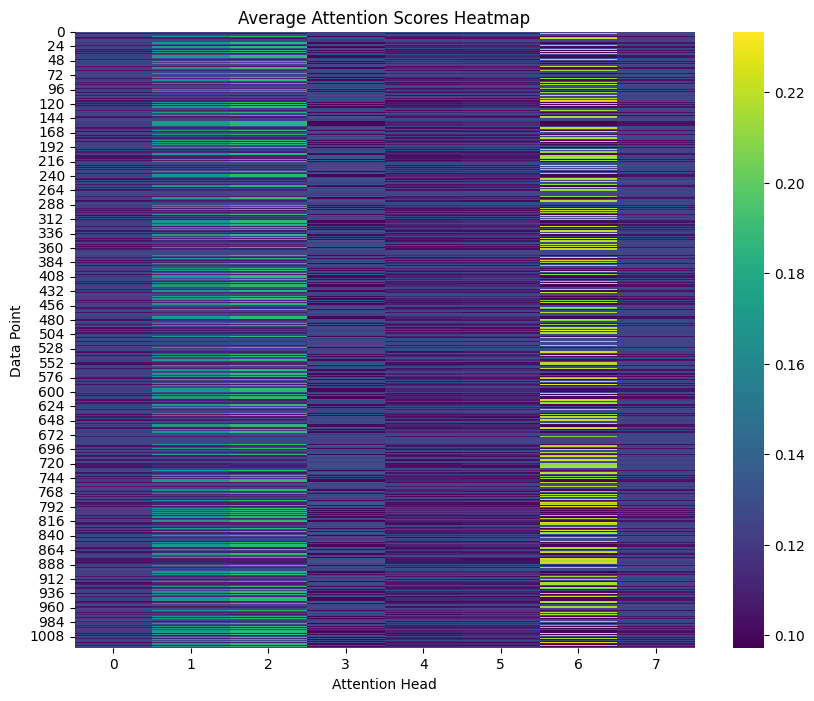

In [56]:
# prompt: visulize att_data column avg_attention over heat map

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'att_data' is your DataFrame with 'avg_attention' column

# Convert the list of attention scores to a matrix
attention_matrix = att_data[att_data.target == 1]['avg_attention'].tolist()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, cmap='viridis')
plt.title('Average Attention Scores Heatmap')
plt.xlabel('Attention Head')
plt.ylabel('Data Point')
plt.show()


In [14]:
# Example usage:
# Assuming you have a sample input sequence from your dataset
sample_input, _ = next(iter(dataloader))

In [16]:
# Print the attention scores for each layer
for layer_idx, layer_attention in enumerate(attention_scores):
  print(f"Layer {layer_idx + 1} Attention Scores:")
  print(layer_attention)

Layer 1 Attention Scores:
tensor([[[[2.4489e-03, 9.6908e-04, 9.5473e-01,  ..., 7.8390e-03,
           1.2539e-02, 5.1569e-03],
          [1.9510e-01, 1.6139e-01, 1.5555e-01,  ..., 6.9800e-02,
           9.3529e-02, 9.9411e-02],
          [3.2252e-01, 2.4238e-01, 1.9097e-02,  ..., 3.1190e-02,
           5.2276e-02, 1.5177e-01],
          ...,
          [2.5645e-01, 2.5478e-01, 3.0321e-02,  ..., 5.5626e-02,
           5.0133e-02, 1.4874e-01],
          [4.1378e-01, 2.0107e-01, 2.6771e-02,  ..., 3.2055e-02,
           3.8702e-02, 1.0974e-01],
          [3.3041e-01, 2.8913e-01, 3.4186e-02,  ..., 1.8029e-02,
           5.4093e-02, 1.0862e-01]],

         [[7.6701e-02, 4.4617e-02, 2.2600e-01,  ..., 8.7779e-02,
           5.5263e-02, 1.3715e-01],
          [1.1005e-01, 6.0325e-02, 1.7725e-01,  ..., 9.0323e-02,
           5.9298e-02, 1.3318e-01],
          [1.1052e-01, 1.6517e-01, 8.1224e-02,  ..., 1.2346e-01,
           2.1978e-01, 1.4185e-01],
          ...,
          [1.3373e-01, 1.6748e-01

In [24]:
layer_attention[0]

tensor([[[0.1162, 0.1275, 0.1232, 0.1281, 0.1259, 0.1269, 0.1271, 0.1251],
         [0.1184, 0.1258, 0.1254, 0.1227, 0.1253, 0.1275, 0.1284, 0.1264],
         [0.1176, 0.1254, 0.1256, 0.1234, 0.1255, 0.1269, 0.1289, 0.1268],
         [0.1170, 0.1262, 0.1258, 0.1228, 0.1260, 0.1277, 0.1282, 0.1262],
         [0.1185, 0.1257, 0.1250, 0.1235, 0.1252, 0.1273, 0.1282, 0.1267],
         [0.1189, 0.1258, 0.1248, 0.1238, 0.1253, 0.1273, 0.1285, 0.1258],
         [0.1209, 0.1253, 0.1249, 0.1242, 0.1247, 0.1264, 0.1279, 0.1257],
         [0.1197, 0.1258, 0.1252, 0.1252, 0.1247, 0.1266, 0.1271, 0.1257]],

        [[0.1282, 0.1312, 0.1243, 0.1119, 0.1238, 0.1288, 0.1276, 0.1241],
         [0.1283, 0.1325, 0.1236, 0.1133, 0.1226, 0.1290, 0.1278, 0.1229],
         [0.1282, 0.1334, 0.1253, 0.1114, 0.1226, 0.1304, 0.1246, 0.1242],
         [0.1254, 0.1306, 0.1280, 0.1161, 0.1267, 0.1310, 0.1143, 0.1279],
         [0.1289, 0.1314, 0.1236, 0.1103, 0.1236, 0.1286, 0.1303, 0.1233],
         [0.1290, 0.131

In [ ]:
# prompt: noramalise or average out multihead atteantion score to get 1x8 values for 1 input sequence

def average_multihead_attention(attention_scores):
  """
  Averages the attention scores across multiple heads for a single input sequence.

  Args:
    attention_scores: A tensor of shape (num_heads, seq_len, seq_len)
                      representing the attention scores for a single input sequence.

  Returns:
    A tensor of shape (seq_len, seq_len) representing the averaged attention scores.
  """
  return torch.mean(attention_scores, dim=0)


# Example usage:
averaged_attention = average_multihead_attention(layer_attention[0])
print(averaged_attention)
# Further, to get a 1x8 vector, you can average over the rows or columns
# or perform other aggregation techniques based on your needs.
# For instance:
averaged_row_wise = torch.mean(averaged_attention, dim=0)
print(averaged_row_wise)
